In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

from design import BaseDesign
from film import TwoMaterialFilm
from spectrum import Spectrum
from optimizer.LM_gradient_descent import LM_optimize_d_simple
from optimizer.adam import AdamThicknessOptimizer
import copy
from utils.loss import calculate_RMS, calculate_RMS_f_spec
import pickle
import designer
from analyze_utils.structure import plot_layer_thickness
from analyze_utils.structure import diff_simple_film
from analyze_utils.result_io import save, load

import matplotlib.patches as mpatches


In [2]:

def make_random_film(N, pert_budget, seed=np.random.random()):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500)
    
    np.random.seed()
    d = np.random.random(N)
    d *= 3000 / np.sum(d)

    film = TwoMaterialFilm('SiO2', 'TiO2', 'Si', d_init=d)
    film.add_spec_param(inc_ang, wls)
    film_pert = copy.deepcopy(film)

    d = copy.deepcopy(d) # change reference of d to new
    pert = np.random.random(d.shape[0])
    d += pert * pert_budget / np.sum(pert)
    film_pert.update_d(d)
    return film, film_pert

def make_pert(dim, budget, rep_num, optimizer, show=False):

    film, film_pert = make_random_film(dim, budget)

    # plot_layer_thickness(film)
    # plot_layer_thickness(film_pert)

    # print(f'before: loss={calculate_RMS(film, film_pert)}')
    adam_optimizer = AdamThicknessOptimizer(
        film_pert, 
        film.get_all_spec_list(), 
        1000, 
        1, 
        show=show,
        record=True,
    )
    record_films, losses = adam_optimizer()
    # print(f'after: loss={calculate_RMS(film, film_pert)}')
    sim = diff_simple_film(film_pert, film)
    return sim, losses




In [3]:

# layer_numbers = [2, 3, 5] + list(np.arange(10, 101, 10))
layer_numbers = np.arange(10, 40, 2)
budget = 100
rep = 50
# in total 30 * 50 rep * 1000 GD steps, or 1.5e6 gd steps, 1.5e4 s = 5 hours

In [4]:
# Exp
last_loss_rep, losses_rep, sims_rep  = [], [], []
for rep_id in range(rep):
    last_loss_rep.append([])
    sims_rep.append([])   
    losses_rep.append([]) 
    for N in layer_numbers:
        print(f'progress: adam, rep{rep_id}, {N} layers, max {layer_numbers[-1]}')
        cur_sim, cur_losses = make_pert(N, budget, optimizer='LM', rep_num=50, show=False)
        print(f'done, loss{cur_losses[-1]}, sim {cur_sim}')

        last_loss_rep[-1].append(min(cur_losses)) # shit... is best_losses_rep
        sims_rep[-1].append(cur_sim)
        losses_rep[-1].append(cur_losses)
        

save(f'./raw_result/result_dif_layers_l1budget_{budget}', last_loss_rep, sims_rep, losses_rep)


done, loss0.00032918496610230666, sim (0.010943039303334706+0j)
progress: adam, rep45, 10 layers, max 38
done, loss0.0001936866517553308, sim (0.00029036766263020313+0j)
progress: adam, rep45, 12 layers, max 38
done, loss8.919660067806008e-16, sim (9.663381206337363e-16+0j)
progress: adam, rep45, 14 layers, max 38
done, loss1.0973582902310202e-05, sim (0.00010506434399333579+0j)
progress: adam, rep45, 16 layers, max 38
done, loss7.315007725728087e-06, sim (1.8914553198131914e-05+0j)
progress: adam, rep45, 18 layers, max 38
done, loss0.0007740660483165068, sim (0.004739275070375636+0j)
progress: adam, rep45, 20 layers, max 38
done, loss4.029927553808582e-07, sim (6.936678662760669e-07+0j)
progress: adam, rep45, 22 layers, max 38
done, loss2.1406299585510987e-07, sim (4.804927696071005e-07+0j)
progress: adam, rep45, 24 layers, max 38
done, loss0.00043554102808214605, sim (0.0061859800071773436+0j)
progress: adam, rep45, 26 layers, max 38
done, loss0.09353358874656377, sim (0.510690229142

In [ ]:
# new analysis

def plot_rep_violin(ax, x, arr, label):
    arr = np.array(arr)
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=500
    )
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )

fig, ax = plt.subplots(1, 1)
plot_rep_violin(ax, layer_numbers, losses_rep, label='')

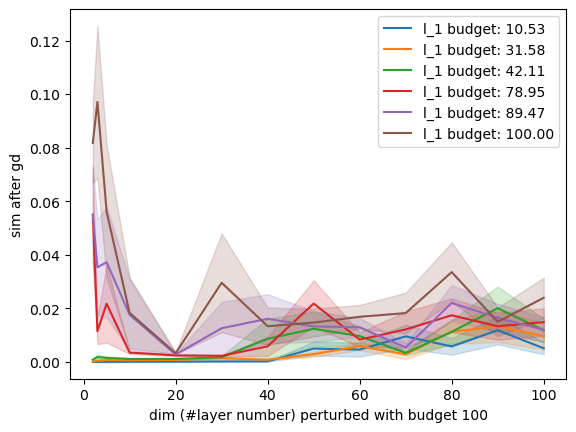

In [129]:
def plot_loss(loss, idx):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for cur_loss, layer_number, i in zip(loss, layer_numbers, range(len(layer_numbers))):
        if i not in idx: 
            continue
        j += 1
        cur_std = np.std(cur_loss, axis=0) / 3
        cur_loss = np.mean(cur_loss, axis=0)
        ax.plot(budgets, cur_loss, label=f'{layer_number} layers', c=f'C{j}')
        ax.fill_between(budgets, cur_loss - cur_std, cur_loss + cur_std, color=f'C{j}', alpha=0.1)

    ax.set_xlabel('pert')
    ax.set_ylabel('loss after gd')
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    ax.legend()

def plot_sim(sim, idx):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for cur_loss, layer_number, i in zip(sim, layer_numbers, range(len(layer_numbers))):
        if i not in idx: 
            continue
        j += 1
        cur_std = np.std(cur_loss, axis=0) / 3
        cur_loss = np.mean(cur_loss, axis=0)
        ax.plot(budgets, cur_loss, label=f'{layer_number} layers', c=f'C{j}')
        ax.fill_between(budgets, cur_loss - cur_std, cur_loss + cur_std, color=f'C{j}', alpha=0.1)

    ax.set_xlabel('pert')
    ax.set_ylabel('difference after gd')
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    ax.legend()

def plot_loss_st_some_pert_budget(loss, idx, plot_budgets):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for k, budget in enumerate(budgets):
        if k not in plot_budgets:
            continue
        j += 1

        stds, losses = [], []
        plot_layers = []
        for cur_loss, layer_number, i in zip(loss, layer_numbers, range(len(layer_numbers))):
            if i not in idx: 
                continue
            stds.append(np.std(cur_loss, axis=0)[k] / 3)
            losses.append(np.mean(cur_loss, axis=0)[k])
            plot_layers.append(layer_number)
        losses, stds = np.array(losses), np.array(stds)
        ax.plot(plot_layers, losses, c=f'C{j}', label=f'l_1 budget: {budget:.2f}')
        ax.fill_between(plot_layers, losses - stds, losses + stds, color=f'C{j}', alpha=0.2)

    ax.set_xlabel('dim (#layer number) perturbed with budget 100')
    ax.set_ylabel('sim after gd')
    # ax.set_yscale('log')
    
    ax.legend()

# idx = [0, 3, 4, 5, 7]
# plot_loss(loss_adam, idx)
# plot_sim(sim_adam, idx)

idx = range(100)
plot_loss_st_some_pert_budget(loss_adam, idx, [2, 6, 8, 15, 17, 19])

# plot_loss(loss_LM)

In [ ]:
def perturb(budget):
    f = FilmSimple('SiO2', 'TiO2', 'SiO2', np.array([100., 100.] * 20))
    # f.add_spec_param(0., np.linspace(500, 1000, 500))
    f.add_spec_param(0., np.linspace(500, 1500, 500))

    from analyze_utils.plot_spectrum import plot_spectrum

    f_target = copy.deepcopy(f)

    pert = np.random.random(f.get_d().shape[0])
    f.update_d(f.get_d() + pert * budget / np.sum(np.abs(pert)))

    adam_optimize(f, f_target.get_all_spec_list(), 500, 1e-1, show=True)
    loss = calculate_RMS(f, f_target)
    similarity = diff_simple_film(f, f_target)
    return loss, similarity

# landscape at low dimension should be: more info, fewer local minima, but not this case in higher dimensions.
# well... seems to be the guilt of LM
# TODO: exp here at low dim (2, 3, 5 layers)
sim, similarity = [], []
budgets = [10, 20, 30, 40, 50, 55, 60, 65, 70, 80, 90, 100]
for _ in range(10):
    sim.append([])
    similarity.append([])
    for budget in budgets:
        l, s = perturb(budget)
        sim[-1].append(l)
        similarity[-1].append(s)


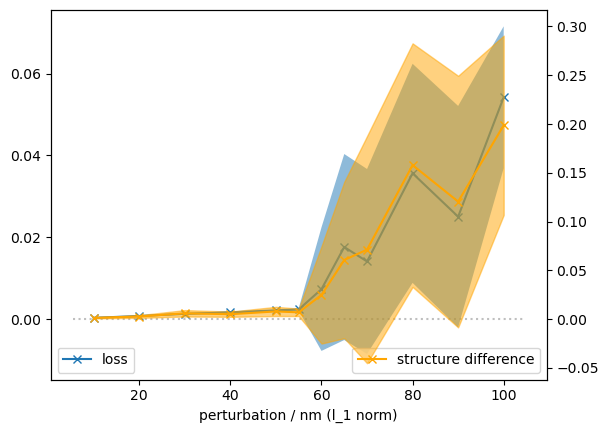

In [11]:
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(budgets, np.mean(sim, axis=0), label='loss', marker='x', zorder=1)
ax.fill_between(budgets, np.mean(sim, axis=0) + np.std(sim, axis=0), np.mean(sim, axis=0) - np.std(sim, axis=0), alpha=0.5, zorder=10)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[-1]], [0, 0], c='grey', alpha=0.5, ls=':')
ax2.plot(budgets, np.mean(similarity, axis=0), label='structure difference', marker='x', c='orange')
ax2.fill_between(budgets, np.mean(similarity, axis=0) - np.std(similarity, axis=0), np.mean(similarity, axis=0) + np.std(similarity, axis=0), color='orange', alpha=0.5, zorder=11)
ax.legend()
ax2.legend(loc='lower right')
ax.legend(loc='lower left')
ax.set_xlabel('perturbation / nm (l_1 norm)')
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2) 
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])
align_yaxis(ax, ax2)